# Transforming New Data with UMAP

UMAP is useful for generating visualisations, but if you want to make use of UMAP more generally for machine learning tasks it is important to be be able to train a model and then laster pass new data to the model and have it transform that data into the learned space. For example if we use UMAP to learn a latent space and then train a classifier on data transformed into the latent space then the classifier is only useful for prediction if we can transform data for which we want a prediction into the latent space the classifier uses. Fortunately UMAP makes this possible, albeit more slowly than some other transformers that allow this.

To demonstrate this functionality we'll make use of [scikit-learn](http://scikit-learn.org/stable/index.html) and the digits dataset contained therein (see "How to Use UMAP" for an example of the digits dataset). First let's load all the modules we'll need to get this done.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(context='notebook', style='white', rc={'figure.figsize':(14,10)})

In [3]:
digits = load_digits()

To keep everything honest let's use sklearn ``train_test_split`` to separate out a training and test set (stratified over the diffierent digit types). By default ``train_test_split`` will carve off 25% of the data for testing, which seems suitable in this case.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, 
                                                    digits.target, 
                                                    stratify=digits.target,
                                                    random_state=42)

Now to get a benchmark idea of what we are looking at let's train a couple of different classifiers and then see how well they score on the test set. For this example lets try a support vector classifier and a KNN classifier. Ideally we should be tuning hyperparameters (perhaps a grid search using k-fold cross validation), but for the purposes of this simple demo we will simply use default parameters for both classifiers.

In [5]:
svc = SVC().fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)

The next question is how well these classifiers perform on the test set. Conveniently sklearn provides a ``score`` method that can output the accuracy on the tets set.

In [6]:
svc.score(X_test, y_test), knn.score(X_test, y_test)

(0.62, 0.9844444444444445)

The result is that the support vector classifier apparently had poor hyper-parameters for this case (I expect with some tuning we could build a much more accurate mode) and the KNN classifier is doing very well.

The goal now is to make use of UMAP as a preprocessing step that one could potentially fit into a pipeline. We will therefore obviously need the ``umap`` module loaded.

In [7]:
import umap

To make use of UMAP as a data transformer we first need to fir the model with the training data. This works exactly as in the "How to Use UMAP" example using the fit method. In this case we simply hand it the training data and it will learn an appropriate (two dimensional by default) embedding.

In [8]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train)

/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/umap_learn-0.3.0-py3.6.egg/umap/spectral.py:188: UserWarning: Embedding 2 connected components using meta-embedding (experimental)


Since we embedded to two dimensions we can visualise the results to ensure that we are getting a potential benefit out of this approach. This is simply a matter of generating a scatterplot with data points colored by the class they come from. Note that the embedded training data can be accessed as the ``.embedding_`` attribute of the UMAP model once we have fit the model to some data.

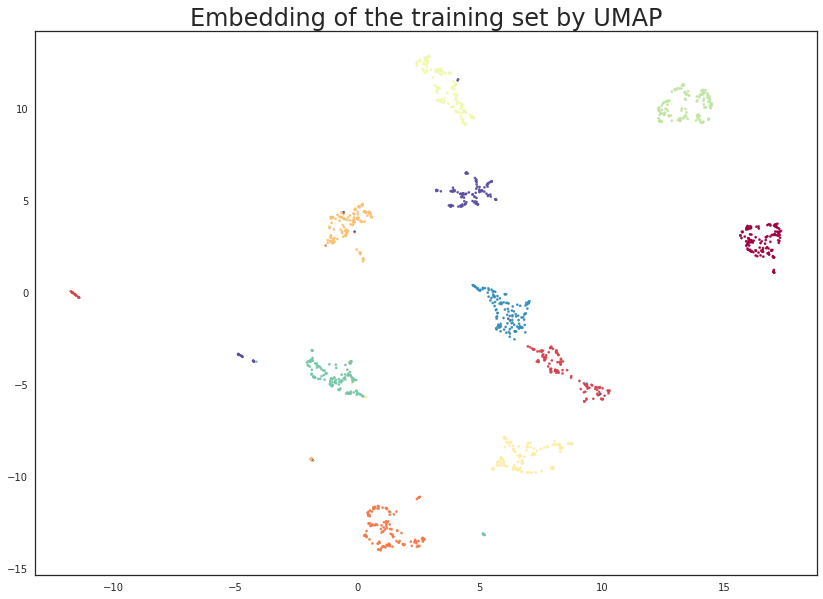

In [9]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24);

This looks very promising! Most of the classes got very cleanly separated, and that gives us some hope that it could help with classifier performance. It is worth noting that this was a completely unsupervised data transform; we could have used the training label information, but that is the subject of [a later tutorial]().

We can now train some new models (again an SVC and a KNN classifier) on the embedded training data. This looks exactly as before but now we pass it the embedded data. Note that calling ``transform`` on input identical to what the model was trained on will simply return the ``embedding_`` attribute, so sklearn pipelines will work as expected.

In [10]:
svc = SVC().fit(trans.embedding_, y_train)
knn = KNeighborsClassifier().fit(trans.embedding_, y_train)

Now we want to work with the test data which none of the models (UMAP or the classifiers) have seen. To do this we use the standard sklearn API and make use of the ``transform`` method, this time handing it the new unseen test data. We will assign this to ``test_embedding`` so that we can take a closer look at the result of applying an existing UMAP model to new data. 

In [17]:
%time test_embedding = trans.transform(X_test)

CPU times: user 867 ms, sys: 70.7 ms, total: 938 ms
Wall time: 335 ms


Note that the transform operations works very efficiently -- taking less than half a second. Compared to some other transformers this is a little on the slow side, but it is fast enough for many uses. Note that as the size of the training and/or test sets increase the performance will slow proportionally. It's also worth noting that the first call to transform may be slow due to Numba JIT overhead -- further runs will be very fast.

The next important question is what the transform did to our test data. In principle we have a new two dimensional representation of the test-set, and ideally this should be based on the existing embedding of the training set. We can check this by visualising the data (since we are in two dimensions) to see if this is true. A simple scatterplot as before will suffice.

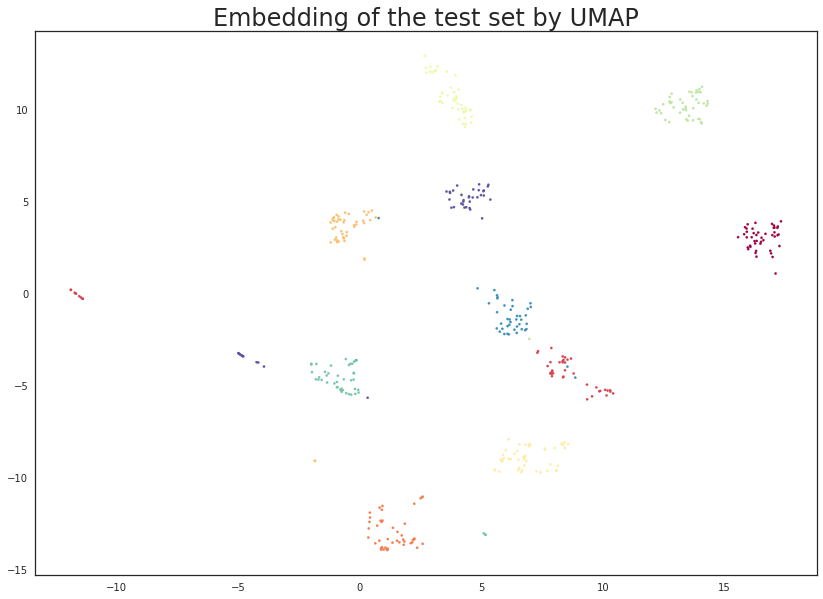

In [12]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=y_test, cmap='Spectral')
plt.title('Embedding of the test set by UMAP', fontsize=24);

The results look like what we should expect; the test data has been embedded into two dimensions in exactly the locations we should expect (by class) given the embedding of the training data visualised above. This means we can now try out of models that were trained on the embedded training data by handing them the newly transformed test set.

In [13]:
svc.score(trans.transform(X_test), y_test), knn.score(trans.transform(X_test), y_test)

(0.9844444444444445, 0.9844444444444445)

The results are pretty good. While the accuracy of the KNN classifier did not improve there was not a lot of scope for improvement given the data. On the other hand the SVC has improved to have equal accuracy to the KNN classifier. Of course we could probably have achieved this level of accuracy by better setting SVC hyper-parameters, but the point here is that we can use UMAP as if it were a standard sklearn transformer as part of an sklearn machine learning pipeline.

Just for fun we can run the same experiments, but this time reduce to ten dimensions (where we can no longer visualise). In practice this will have little gain in this case -- for the digits dataset two dimensions is plenty for UMAP and more dimensions won't help. On the other had for more complex datasets where more dimensions may allow for a much more faithful embedding it is worth noting that we are not restricted to only two dimension.

In [14]:
trans = umap.UMAP(n_neighbors=5, n_components=10, random_state=42).fit(X_train)

/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/umap_learn-0.3.0-py3.6.egg/umap/spectral.py:188: UserWarning: Embedding 2 connected components using meta-embedding (experimental)


In [15]:
svc = SVC().fit(trans.embedding_, y_train)
knn = KNeighborsClassifier().fit(trans.embedding_, y_train)

In [16]:
svc.score(trans.transform(X_test), y_test), knn.score(trans.transform(X_test), y_test)

(0.9822222222222222, 0.9822222222222222)

And we see that in this case we actually marginally lowered our accuracy scores (within the potential noise in such scoring mind you). However for more interesting datasets the larger dimensional embedding may have been a sigificant gain -- it is certainly worth exploring as one of the parameters in a grid search across a pipeline that includes UMAP.